In [1]:
from u import *
from ut import *
from model import *
from data import *

%load_ext autoreload
%autoreload 2

decoder = (Cache / 'vocab.npy').load()
encoder = get_encoder(decoder)
n_vocab = len(decoder)

In [2]:
import distiller
from main import get_net, get_opt, evaluate
c = Config(Wiki / 'shallow,layers_8,cache,long,norm,top_30,first', device='cuda:0', logger=False, local_rank=0).load()
net = get_net(c)
data_tr = SampleIterator(c, c.train_batch, split='valid' if c.debug else 'train')
iter_tr = iter(data_tr)
data_val = SequentialIterator(c, c.eval_batch, split='valid')

In [3]:
distill_str = """
pruners:
  test_pruner:
      class: AutomatedGradualPruner
      initial_sparsity: 0.01
      final_sparsity: 1.00
      weights: []
policies:
  - pruner:
      instance_name: test_pruner
    starting_epoch: 0
    ending_epoch: 40
    frequency: 1
"""

In [4]:
def evaluate_step():
    density = distiller.density(layer_matrix)
    loss = evaluate(c, data_val, net)['loss']
    ppl = np.e ** loss if loss < 5 else np.nan
    return density, ppl

with torch.no_grad():
    info = OrderedDict()
    for layer_name, layer_matrix in tqdm(net.named_parameters()):
        numel = layer_matrix.numel()
        if numel < 5000:
            continue
        print(layer_name)
        c.init_model(net, step='max', train=False)
        d_c = yaml.load(distill_str)
        d_c['pruners']['test_pruner']['weights'].append(layer_name)
        compression_scheduler = distiller.config.dict_config(net, None, d_c)
        info_layer = []
        
        print('Initial density %.5g ppl %.5g' % evaluate_step())
        for epoch in range(40):
            compression_scheduler.on_epoch_begin(epoch)
            compression_scheduler.on_minibatch_begin(epoch, minibatch_id=1, minibatches_per_epoch=1)
            x = to_torch(next(iter_tr), c.device).t()
            inputs, labels = x[:-1], x[1:]
            preds = net(inputs, labels)
            loss = preds['loss']
            loss = compression_scheduler.before_backward_pass(epoch, minibatch_id=1,
                                                                   minibatches_per_epoch=1,
                                                                   loss=loss, return_loss_components=False)
            compression_scheduler.on_minibatch_end(epoch, minibatch_id=1, minibatches_per_epoch=1)
            compression_scheduler.on_epoch_end(epoch)
            density, ppl = evaluate_step()
            print('Epoch %s density %.5g ppl %.5g' % (epoch + 1, density, ppl))
            info_layer.append([epoch, density, ppl])
            if np.isnan(ppl) or ppl > 40:
                break
        print()
        info[layer_name] = (numel, info_layer)

0it [00:00, ?it/s]

embed.layers.0.weight
Initial density 1 ppl 30.862
Epoch 1 density 0.99 ppl 30.863
Epoch 2 density 0.91578 ppl 30.907
Epoch 3 density 0.84537 ppl 31.159
Epoch 4 density 0.77866 ppl 31.833
Epoch 5 density 0.71556 ppl 33.223
Epoch 6 density 0.65596 ppl 35.194
Epoch 7 density 0.59977 ppl 38.121


1it [00:21, 21.51s/it]

Epoch 8 density 0.54688 ppl 42.287

embed.layers.1.weight
Initial density 1 ppl 30.862
Epoch 1 density 0.99 ppl 30.862
Epoch 2 density 0.91578 ppl 30.87
Epoch 3 density 0.84537 ppl 30.922
Epoch 4 density 0.77866 ppl 31.046
Epoch 5 density 0.71556 ppl 31.244
Epoch 6 density 0.65596 ppl 31.521
Epoch 7 density 0.59977 ppl 31.937
Epoch 8 density 0.54688 ppl 32.472
Epoch 9 density 0.49719 ppl 33.175
Epoch 10 density 0.45061 ppl 34.006
Epoch 11 density 0.40704 ppl 34.985
Epoch 12 density 0.36637 ppl 36.206
Epoch 13 density 0.3285 ppl 37.57
Epoch 14 density 0.29333 ppl 39.267


2it [00:50, 23.79s/it]

Epoch 15 density 0.26077 ppl 41.147

embed.layers.2.weight
Initial density 1 ppl 30.862
Epoch 1 density 0.99 ppl 30.862
Epoch 2 density 0.91578 ppl 30.868
Epoch 3 density 0.84537 ppl 30.904
Epoch 4 density 0.77866 ppl 31
Epoch 5 density 0.71556 ppl 31.135
Epoch 6 density 0.65596 ppl 31.361
Epoch 7 density 0.59977 ppl 31.627
Epoch 8 density 0.54688 ppl 31.916
Epoch 9 density 0.4972 ppl 32.294
Epoch 10 density 0.45061 ppl 32.631
Epoch 11 density 0.40704 ppl 33.089
Epoch 12 density 0.36637 ppl 33.444
Epoch 13 density 0.3285 ppl 33.919
Epoch 14 density 0.29333 ppl 34.288
Epoch 15 density 0.26077 ppl 34.688
Epoch 16 density 0.23072 ppl 35.065
Epoch 17 density 0.20306 ppl 35.374
Epoch 18 density 0.17771 ppl 35.687
Epoch 19 density 0.15456 ppl 35.942
Epoch 20 density 0.13352 ppl 36.147
Epoch 21 density 0.11447 ppl 36.317
Epoch 22 density 0.097334 ppl 36.459
Epoch 23 density 0.081996 ppl 36.626
Epoch 24 density 0.068361 ppl 36.777
Epoch 25 density 0.056327 ppl 36.97
Epoch 26 density 0.045796 p

3it [02:05, 39.15s/it]

Epoch 40 density 0 ppl 36.205

embed.projections.0.weight
Initial density 1 ppl 30.862
Epoch 1 density 0.99005 ppl 30.862
Epoch 2 density 0.91583 ppl 30.866
Epoch 3 density 0.8454 ppl 30.876
Epoch 4 density 0.77869 ppl 30.904
Epoch 5 density 0.71558 ppl 30.963
Epoch 6 density 0.65601 ppl 31.035
Epoch 7 density 0.59979 ppl 31.139
Epoch 8 density 0.54694 ppl 31.274
Epoch 9 density 0.49725 ppl 31.44
Epoch 10 density 0.45062 ppl 31.66
Epoch 11 density 0.40704 ppl 31.923
Epoch 12 density 0.36639 ppl 32.239
Epoch 13 density 0.32855 ppl 32.644
Epoch 14 density 0.29333 ppl 33.082
Epoch 15 density 0.2608 ppl 33.628
Epoch 16 density 0.23077 ppl 34.188
Epoch 17 density 0.20306 ppl 34.895
Epoch 18 density 0.17773 ppl 35.588
Epoch 19 density 0.1546 ppl 36.458
Epoch 20 density 0.13354 ppl 37.378
Epoch 21 density 0.1145 ppl 38.353
Epoch 22 density 0.097351 ppl 39.323


4it [02:49, 40.53s/it]

Epoch 23 density 0.082031 ppl 40.488

layers.0.qkv.weight
Initial density 1 ppl 30.862
Epoch 1 density 0.99 ppl 30.862
Epoch 2 density 0.91579 ppl 30.866
Epoch 3 density 0.84537 ppl 30.897
Epoch 4 density 0.77867 ppl 30.95
Epoch 5 density 0.71556 ppl 31.038
Epoch 6 density 0.65597 ppl 31.196
Epoch 7 density 0.59977 ppl 31.435
Epoch 8 density 0.54688 ppl 31.722
Epoch 9 density 0.4972 ppl 32.154
Epoch 10 density 0.45062 ppl 32.634
Epoch 11 density 0.40704 ppl 33.248
Epoch 12 density 0.36637 ppl 34.395
Epoch 13 density 0.3285 ppl 35.678
Epoch 14 density 0.29333 ppl 37.033
Epoch 15 density 0.26078 ppl 38.344
Epoch 16 density 0.23072 ppl 39.798


9it [03:22, 30.35s/it]

Epoch 17 density 0.20306 ppl 41.211

layers.0.out.weight
Initial density 1 ppl 30.862
Epoch 1 density 0.99001 ppl 30.863
Epoch 2 density 0.91579 ppl 30.861
Epoch 3 density 0.84538 ppl 30.865
Epoch 4 density 0.77867 ppl 30.878
Epoch 5 density 0.71558 ppl 30.905
Epoch 6 density 0.65597 ppl 30.952
Epoch 7 density 0.59977 ppl 31.016
Epoch 8 density 0.5469 ppl 31.141
Epoch 9 density 0.49721 ppl 31.276
Epoch 10 density 0.45062 ppl 31.465
Epoch 11 density 0.40704 ppl 31.708
Epoch 12 density 0.36637 ppl 32.03
Epoch 13 density 0.32851 ppl 32.413
Epoch 14 density 0.29333 ppl 32.877
Epoch 15 density 0.26078 ppl 33.458
Epoch 16 density 0.23073 ppl 34.184
Epoch 17 density 0.20306 ppl 35.08
Epoch 18 density 0.17771 ppl 35.818
Epoch 19 density 0.15456 ppl 36.816
Epoch 20 density 0.13352 ppl 37.763
Epoch 21 density 0.11448 ppl 38.809


11it [04:04, 27.54s/it]

Epoch 22 density 0.097351 ppl 40.275

layers.0.fc.0.weight
Initial density 1 ppl 30.862
Epoch 1 density 0.99 ppl 30.862
Epoch 2 density 0.91579 ppl 30.866
Epoch 3 density 0.84537 ppl 30.894
Epoch 4 density 0.77867 ppl 30.975
Epoch 5 density 0.71556 ppl 31.134
Epoch 6 density 0.65597 ppl 31.339
Epoch 7 density 0.59977 ppl 31.643
Epoch 8 density 0.54688 ppl 32.067
Epoch 9 density 0.4972 ppl 32.736
Epoch 10 density 0.45062 ppl 33.534
Epoch 11 density 0.40704 ppl 34.687
Epoch 12 density 0.36637 ppl 36.13
Epoch 13 density 0.3285 ppl 38.069


14it [04:31, 22.01s/it]

Epoch 14 density 0.29333 ppl 40.736

layers.0.fc.3.weight
Initial density 1 ppl 30.862
Epoch 1 density 0.99 ppl 30.862
Epoch 2 density 0.91579 ppl 30.885
Epoch 3 density 0.84537 ppl 30.963
Epoch 4 density 0.77867 ppl 31.091
Epoch 5 density 0.71556 ppl 31.349
Epoch 6 density 0.65597 ppl 31.629
Epoch 7 density 0.59977 ppl 32.018
Epoch 8 density 0.54688 ppl 32.774
Epoch 9 density 0.4972 ppl 33.352
Epoch 10 density 0.45062 ppl 34.693
Epoch 11 density 0.40704 ppl 35.471
Epoch 12 density 0.36637 ppl 36.695
Epoch 13 density 0.3285 ppl 38.068
Epoch 14 density 0.29333 ppl 39.976


16it [05:00, 19.80s/it]

Epoch 15 density 0.26077 ppl 41.669

layers.1.qkv.weight
Initial density 1 ppl 30.862
Epoch 1 density 0.99 ppl 30.861
Epoch 2 density 0.91579 ppl 30.862
Epoch 3 density 0.84537 ppl 30.869
Epoch 4 density 0.77867 ppl 30.891
Epoch 5 density 0.71556 ppl 30.934
Epoch 6 density 0.65597 ppl 30.996
Epoch 7 density 0.59977 ppl 31.103
Epoch 8 density 0.54688 ppl 31.259
Epoch 9 density 0.4972 ppl 31.455
Epoch 10 density 0.45062 ppl 31.785
Epoch 11 density 0.40704 ppl 32.151
Epoch 12 density 0.36637 ppl 32.746
Epoch 13 density 0.3285 ppl 33.484
Epoch 14 density 0.29333 ppl 34.318
Epoch 15 density 0.26078 ppl 35.213
Epoch 16 density 0.23072 ppl 36.145
Epoch 17 density 0.20306 ppl 36.956
Epoch 18 density 0.17771 ppl 37.702
Epoch 19 density 0.15456 ppl 38.196
Epoch 20 density 0.13352 ppl 38.706
Epoch 21 density 0.11447 ppl 39.085
Epoch 22 density 0.097338 ppl 39.403
Epoch 23 density 0.081997 ppl 39.549
Epoch 24 density 0.068366 ppl 39.71
Epoch 25 density 0.056329 ppl 39.791
Epoch 26 density 0.045797

21it [05:56, 17.18s/it]

Epoch 29 density 0.022217 ppl 40.02

layers.1.out.weight
Initial density 1 ppl 30.862
Epoch 1 density 0.99001 ppl 30.862
Epoch 2 density 0.91579 ppl 30.862
Epoch 3 density 0.84538 ppl 30.861
Epoch 4 density 0.77867 ppl 30.87
Epoch 5 density 0.71558 ppl 30.881
Epoch 6 density 0.65597 ppl 30.909
Epoch 7 density 0.59977 ppl 30.937
Epoch 8 density 0.5469 ppl 30.987
Epoch 9 density 0.49721 ppl 31.029
Epoch 10 density 0.45062 ppl 31.084
Epoch 11 density 0.40704 ppl 31.164
Epoch 12 density 0.36637 ppl 31.249
Epoch 13 density 0.32851 ppl 31.353
Epoch 14 density 0.29333 ppl 31.437
Epoch 15 density 0.26078 ppl 31.524
Epoch 16 density 0.23073 ppl 31.691
Epoch 17 density 0.20306 ppl 31.823
Epoch 18 density 0.17771 ppl 32.049
Epoch 19 density 0.15456 ppl 32.24
Epoch 20 density 0.13352 ppl 32.481
Epoch 21 density 0.11448 ppl 32.773
Epoch 22 density 0.097351 ppl 33.073
Epoch 23 density 0.082011 ppl 33.399
Epoch 24 density 0.06838 ppl 33.706
Epoch 25 density 0.056335 ppl 34.173
Epoch 26 density 0.0457

23it [07:11, 23.38s/it]

Epoch 40 density 0 ppl 38.411

layers.1.fc.0.weight
Initial density 1 ppl 30.862
Epoch 1 density 0.99 ppl 30.861
Epoch 2 density 0.91579 ppl 30.865
Epoch 3 density 0.84537 ppl 30.885
Epoch 4 density 0.77867 ppl 30.927
Epoch 5 density 0.71556 ppl 30.996
Epoch 6 density 0.65597 ppl 31.139
Epoch 7 density 0.59977 ppl 31.351
Epoch 8 density 0.54688 ppl 31.609
Epoch 9 density 0.4972 ppl 31.898
Epoch 10 density 0.45062 ppl 32.258
Epoch 11 density 0.40704 ppl 32.659
Epoch 12 density 0.36637 ppl 33.177
Epoch 13 density 0.3285 ppl 33.801
Epoch 14 density 0.29333 ppl 34.302
Epoch 15 density 0.26077 ppl 35.036
Epoch 16 density 0.23072 ppl 35.587
Epoch 17 density 0.20306 ppl 36.269
Epoch 18 density 0.17771 ppl 36.941
Epoch 19 density 0.15456 ppl 37.894
Epoch 20 density 0.13352 ppl 38.949


26it [07:52, 20.44s/it]

Epoch 21 density 0.11448 ppl 40.032

layers.1.fc.3.weight
Initial density 1 ppl 30.862
Epoch 1 density 0.99 ppl 30.862
Epoch 2 density 0.91579 ppl 30.864
Epoch 3 density 0.84537 ppl 30.871
Epoch 4 density 0.77867 ppl 30.932
Epoch 5 density 0.71556 ppl 31.006
Epoch 6 density 0.65597 ppl 31.126
Epoch 7 density 0.59977 ppl 31.272
Epoch 8 density 0.54688 ppl 31.497
Epoch 9 density 0.4972 ppl 31.764
Epoch 10 density 0.45062 ppl 32.139
Epoch 11 density 0.40704 ppl 32.545
Epoch 12 density 0.36637 ppl 33.035
Epoch 13 density 0.3285 ppl 33.562
Epoch 14 density 0.29333 ppl 34.211
Epoch 15 density 0.26077 ppl 34.825
Epoch 16 density 0.23072 ppl 35.737
Epoch 17 density 0.20306 ppl 36.687
Epoch 18 density 0.17771 ppl 37.756
Epoch 19 density 0.15456 ppl 39.299


28it [08:31, 20.14s/it]

Epoch 20 density 0.13352 ppl 40.559

layers.2.qkv.weight
Initial density 1 ppl 30.862
Epoch 1 density 0.99 ppl 30.863
Epoch 2 density 0.91579 ppl 30.866
Epoch 3 density 0.84537 ppl 30.883
Epoch 4 density 0.77867 ppl 30.916
Epoch 5 density 0.71556 ppl 30.979
Epoch 6 density 0.65597 ppl 31.086
Epoch 7 density 0.59977 ppl 31.293
Epoch 8 density 0.54688 ppl 31.59
Epoch 9 density 0.4972 ppl 32.025
Epoch 10 density 0.45062 ppl 32.655
Epoch 11 density 0.40704 ppl 33.492
Epoch 12 density 0.36637 ppl 34.672
Epoch 13 density 0.3285 ppl 36.314
Epoch 14 density 0.29333 ppl 37.87
Epoch 15 density 0.26078 ppl 39.605


33it [09:02, 15.98s/it]

Epoch 16 density 0.23072 ppl 41.615

layers.2.out.weight
Initial density 1 ppl 30.862
Epoch 1 density 0.99001 ppl 30.863
Epoch 2 density 0.91579 ppl 30.863
Epoch 3 density 0.84538 ppl 30.866
Epoch 4 density 0.77867 ppl 30.881
Epoch 5 density 0.71558 ppl 30.913
Epoch 6 density 0.65597 ppl 30.939
Epoch 7 density 0.59977 ppl 30.983
Epoch 8 density 0.5469 ppl 31.064
Epoch 9 density 0.49721 ppl 31.17
Epoch 10 density 0.45062 ppl 31.252
Epoch 11 density 0.40704 ppl 31.381
Epoch 12 density 0.36637 ppl 31.56
Epoch 13 density 0.32851 ppl 31.77
Epoch 14 density 0.29333 ppl 31.991
Epoch 15 density 0.26078 ppl 32.272
Epoch 16 density 0.23073 ppl 32.591
Epoch 17 density 0.20306 ppl 33.012
Epoch 18 density 0.17771 ppl 33.413
Epoch 19 density 0.15456 ppl 33.97
Epoch 20 density 0.13352 ppl 34.609
Epoch 21 density 0.11448 ppl 35.248
Epoch 22 density 0.097351 ppl 36.123
Epoch 23 density 0.082011 ppl 36.867
Epoch 24 density 0.06838 ppl 37.765
Epoch 25 density 0.056335 ppl 38.718
Epoch 26 density 0.045797

35it [09:54, 18.93s/it]

Epoch 27 density 0.036682 ppl 40.8

layers.2.fc.0.weight
Initial density 1 ppl 30.862
Epoch 1 density 0.99 ppl 30.863
Epoch 2 density 0.91579 ppl 30.863
Epoch 3 density 0.84537 ppl 30.876
Epoch 4 density 0.77867 ppl 30.912
Epoch 5 density 0.71556 ppl 31.002
Epoch 6 density 0.65597 ppl 31.106
Epoch 7 density 0.59977 ppl 31.283
Epoch 8 density 0.54688 ppl 31.43
Epoch 9 density 0.4972 ppl 31.678
Epoch 10 density 0.45062 ppl 31.958
Epoch 11 density 0.40704 ppl 32.23
Epoch 12 density 0.36637 ppl 32.636
Epoch 13 density 0.3285 ppl 33.01
Epoch 14 density 0.29333 ppl 33.426
Epoch 15 density 0.26077 ppl 33.864
Epoch 16 density 0.23072 ppl 34.255
Epoch 17 density 0.20306 ppl 34.732
Epoch 18 density 0.17771 ppl 35.181
Epoch 19 density 0.15456 ppl 35.584
Epoch 20 density 0.13352 ppl 36.079
Epoch 21 density 0.11448 ppl 36.711
Epoch 22 density 0.097336 ppl 37.24
Epoch 23 density 0.081996 ppl 37.741
Epoch 24 density 0.068364 ppl 38.209
Epoch 25 density 0.05633 ppl 38.743
Epoch 26 density 0.045797 ppl

38it [10:48, 18.61s/it]

Epoch 28 density 0.028844 ppl 40.318

layers.2.fc.3.weight
Initial density 1 ppl 30.862
Epoch 1 density 0.99 ppl 30.863
Epoch 2 density 0.91579 ppl 30.863
Epoch 3 density 0.84537 ppl 30.873
Epoch 4 density 0.77867 ppl 30.889
Epoch 5 density 0.71556 ppl 30.92
Epoch 6 density 0.65597 ppl 30.972
Epoch 7 density 0.59977 ppl 31.051
Epoch 8 density 0.54688 ppl 31.128
Epoch 9 density 0.4972 ppl 31.245
Epoch 10 density 0.45062 ppl 31.419
Epoch 11 density 0.40704 ppl 31.61
Epoch 12 density 0.36637 ppl 31.806
Epoch 13 density 0.3285 ppl 32.031
Epoch 14 density 0.29333 ppl 32.29
Epoch 15 density 0.26077 ppl 32.557
Epoch 16 density 0.23072 ppl 32.848
Epoch 17 density 0.20306 ppl 33.211
Epoch 18 density 0.17771 ppl 33.53
Epoch 19 density 0.15456 ppl 33.986
Epoch 20 density 0.13352 ppl 34.368
Epoch 21 density 0.11448 ppl 34.841
Epoch 22 density 0.097336 ppl 35.391
Epoch 23 density 0.081996 ppl 35.954
Epoch 24 density 0.068364 ppl 36.567
Epoch 25 density 0.05633 ppl 36.973
Epoch 26 density 0.045797 p

40it [11:48, 22.16s/it]

Epoch 32 density 0.00855 ppl 40.042

layers.3.qkv.weight
Initial density 1 ppl 30.862
Epoch 1 density 0.99 ppl 30.861
Epoch 2 density 0.91579 ppl 30.875
Epoch 3 density 0.84537 ppl 30.901
Epoch 4 density 0.77867 ppl 30.932
Epoch 5 density 0.71556 ppl 30.997
Epoch 6 density 0.65597 ppl 31.073
Epoch 7 density 0.59977 ppl 31.164
Epoch 8 density 0.54688 ppl 31.283
Epoch 9 density 0.4972 ppl 31.486
Epoch 10 density 0.45062 ppl 31.623
Epoch 11 density 0.40704 ppl 31.891
Epoch 12 density 0.36637 ppl 32.169
Epoch 13 density 0.3285 ppl 32.49
Epoch 14 density 0.29333 ppl 32.907
Epoch 15 density 0.26078 ppl 33.373
Epoch 16 density 0.23072 ppl 33.853
Epoch 17 density 0.20306 ppl 34.378
Epoch 18 density 0.17771 ppl 34.846
Epoch 19 density 0.15456 ppl 35.235
Epoch 20 density 0.13352 ppl 35.722
Epoch 21 density 0.11447 ppl 36.077
Epoch 22 density 0.097338 ppl 36.321
Epoch 23 density 0.081997 ppl 36.63
Epoch 24 density 0.068366 ppl 36.707
Epoch 25 density 0.056329 ppl 36.78
Epoch 26 density 0.045797 p

45it [13:04, 20.05s/it]

Epoch 40 density 0 ppl 36.944

layers.3.out.weight
Initial density 1 ppl 30.862
Epoch 1 density 0.99001 ppl 30.862
Epoch 2 density 0.91579 ppl 30.863
Epoch 3 density 0.84538 ppl 30.866
Epoch 4 density 0.77867 ppl 30.87
Epoch 5 density 0.71558 ppl 30.885
Epoch 6 density 0.65597 ppl 30.902
Epoch 7 density 0.59977 ppl 30.929
Epoch 8 density 0.5469 ppl 30.971
Epoch 9 density 0.49721 ppl 31.021
Epoch 10 density 0.45062 ppl 31.094
Epoch 11 density 0.40704 ppl 31.181
Epoch 12 density 0.36637 ppl 31.278
Epoch 13 density 0.32851 ppl 31.405
Epoch 14 density 0.29333 ppl 31.558
Epoch 15 density 0.26078 ppl 31.71
Epoch 16 density 0.23073 ppl 31.867
Epoch 17 density 0.20306 ppl 32.025
Epoch 18 density 0.17771 ppl 32.273
Epoch 19 density 0.15456 ppl 32.518
Epoch 20 density 0.13352 ppl 32.842
Epoch 21 density 0.11448 ppl 32.946
Epoch 22 density 0.097351 ppl 33.287
Epoch 23 density 0.082011 ppl 33.597
Epoch 24 density 0.06838 ppl 33.867
Epoch 25 density 0.056335 ppl 34.019
Epoch 26 density 0.045797 ppl

47it [14:19, 25.32s/it]

Epoch 40 density 0 ppl 36.955

layers.3.fc.0.weight
Initial density 1 ppl 30.862
Epoch 1 density 0.99 ppl 30.863
Epoch 2 density 0.91579 ppl 30.863
Epoch 3 density 0.84537 ppl 30.88
Epoch 4 density 0.77867 ppl 30.93
Epoch 5 density 0.71556 ppl 31.017
Epoch 6 density 0.65597 ppl 31.098
Epoch 7 density 0.59977 ppl 31.232
Epoch 8 density 0.54688 ppl 31.418
Epoch 9 density 0.4972 ppl 31.607
Epoch 10 density 0.45062 ppl 31.822
Epoch 11 density 0.40704 ppl 32.093
Epoch 12 density 0.36637 ppl 32.443
Epoch 13 density 0.3285 ppl 32.716
Epoch 14 density 0.29333 ppl 33.125
Epoch 15 density 0.26077 ppl 33.475
Epoch 16 density 0.23072 ppl 33.914
Epoch 17 density 0.20306 ppl 34.345
Epoch 18 density 0.17771 ppl 34.786
Epoch 19 density 0.15456 ppl 35.186
Epoch 20 density 0.13352 ppl 35.634
Epoch 21 density 0.11448 ppl 36.153
Epoch 22 density 0.097336 ppl 36.614
Epoch 23 density 0.081996 ppl 36.879
Epoch 24 density 0.068364 ppl 37.454
Epoch 25 density 0.05633 ppl 37.866
Epoch 26 density 0.045797 ppl 38

50it [15:17, 23.47s/it]

Epoch 30 density 0.016693 ppl 40.234

layers.3.fc.3.weight
Initial density 1 ppl 30.862
Epoch 1 density 0.99 ppl 30.862
Epoch 2 density 0.91579 ppl 30.865
Epoch 3 density 0.84537 ppl 30.874
Epoch 4 density 0.77867 ppl 30.901
Epoch 5 density 0.71556 ppl 30.936
Epoch 6 density 0.65597 ppl 30.997
Epoch 7 density 0.59977 ppl 31.071
Epoch 8 density 0.54688 ppl 31.177
Epoch 9 density 0.4972 ppl 31.268
Epoch 10 density 0.45062 ppl 31.426
Epoch 11 density 0.40704 ppl 31.57
Epoch 12 density 0.36637 ppl 31.751
Epoch 13 density 0.3285 ppl 31.999
Epoch 14 density 0.29333 ppl 32.273
Epoch 15 density 0.26077 ppl 32.573
Epoch 16 density 0.23072 ppl 32.922
Epoch 17 density 0.20306 ppl 33.26
Epoch 18 density 0.17771 ppl 33.556
Epoch 19 density 0.15456 ppl 33.917
Epoch 20 density 0.13352 ppl 34.273
Epoch 21 density 0.11448 ppl 34.642
Epoch 22 density 0.097336 ppl 35.157
Epoch 23 density 0.081996 ppl 35.619
Epoch 24 density 0.068364 ppl 36.122
Epoch 25 density 0.05633 ppl 36.549
Epoch 26 density 0.045797

52it [16:20, 25.87s/it]

Epoch 33 density 0.0057271 ppl 40.147

layers.4.qkv.weight
Initial density 1 ppl 30.862
Epoch 1 density 0.99 ppl 30.863
Epoch 2 density 0.91579 ppl 30.865
Epoch 3 density 0.84537 ppl 30.883
Epoch 4 density 0.77867 ppl 30.919
Epoch 5 density 0.71556 ppl 30.967
Epoch 6 density 0.65597 ppl 31.072
Epoch 7 density 0.59977 ppl 31.2
Epoch 8 density 0.54688 ppl 31.387
Epoch 9 density 0.4972 ppl 31.629
Epoch 10 density 0.45062 ppl 31.944
Epoch 11 density 0.40704 ppl 32.343
Epoch 12 density 0.36637 ppl 32.79
Epoch 13 density 0.3285 ppl 33.235
Epoch 14 density 0.29333 ppl 33.728
Epoch 15 density 0.26078 ppl 34.257
Epoch 16 density 0.23072 ppl 34.822
Epoch 17 density 0.20306 ppl 35.272
Epoch 18 density 0.17771 ppl 35.661
Epoch 19 density 0.15456 ppl 36.038
Epoch 20 density 0.13352 ppl 36.34
Epoch 21 density 0.11447 ppl 36.588
Epoch 22 density 0.097338 ppl 36.786
Epoch 23 density 0.081997 ppl 36.961
Epoch 24 density 0.068366 ppl 37.057
Epoch 25 density 0.056329 ppl 37.088
Epoch 26 density 0.045797 

57it [17:36, 22.66s/it]

Epoch 40 density 0 ppl 37.103

layers.4.out.weight
Initial density 1 ppl 30.862
Epoch 1 density 0.99001 ppl 30.862
Epoch 2 density 0.91579 ppl 30.865
Epoch 3 density 0.84538 ppl 30.869
Epoch 4 density 0.77867 ppl 30.882
Epoch 5 density 0.71558 ppl 30.906
Epoch 6 density 0.65597 ppl 30.941
Epoch 7 density 0.59977 ppl 31.001
Epoch 8 density 0.5469 ppl 31.075
Epoch 9 density 0.49721 ppl 31.133
Epoch 10 density 0.45062 ppl 31.221
Epoch 11 density 0.40704 ppl 31.326
Epoch 12 density 0.36637 ppl 31.437
Epoch 13 density 0.32851 ppl 31.591
Epoch 14 density 0.29333 ppl 31.78
Epoch 15 density 0.26078 ppl 31.985
Epoch 16 density 0.23073 ppl 32.166
Epoch 17 density 0.20306 ppl 32.344
Epoch 18 density 0.17771 ppl 32.612
Epoch 19 density 0.15456 ppl 32.849
Epoch 20 density 0.13352 ppl 33.14
Epoch 21 density 0.11448 ppl 33.429
Epoch 22 density 0.097351 ppl 33.811
Epoch 23 density 0.082011 ppl 34.087
Epoch 24 density 0.06838 ppl 34.371
Epoch 25 density 0.056335 ppl 34.719
Epoch 26 density 0.045797 ppl

59it [18:51, 27.25s/it]

Epoch 40 density 0 ppl 37.153

layers.4.fc.0.weight
Initial density 1 ppl 30.862
Epoch 1 density 0.99 ppl 30.862
Epoch 2 density 0.91579 ppl 30.864
Epoch 3 density 0.84537 ppl 30.881
Epoch 4 density 0.77867 ppl 30.92
Epoch 5 density 0.71556 ppl 30.998
Epoch 6 density 0.65597 ppl 31.096
Epoch 7 density 0.59977 ppl 31.24
Epoch 8 density 0.54688 ppl 31.389
Epoch 9 density 0.4972 ppl 31.583
Epoch 10 density 0.45062 ppl 31.807
Epoch 11 density 0.40704 ppl 32.103
Epoch 12 density 0.36637 ppl 32.387
Epoch 13 density 0.3285 ppl 32.734
Epoch 14 density 0.29333 ppl 33.114
Epoch 15 density 0.26077 ppl 33.426
Epoch 16 density 0.23072 ppl 33.865
Epoch 17 density 0.20306 ppl 34.3
Epoch 18 density 0.17771 ppl 34.74
Epoch 19 density 0.15456 ppl 35.156
Epoch 20 density 0.13352 ppl 35.745
Epoch 21 density 0.11448 ppl 36.369
Epoch 22 density 0.097336 ppl 36.979
Epoch 23 density 0.081996 ppl 37.636
Epoch 24 density 0.068364 ppl 38.323
Epoch 25 density 0.05633 ppl 38.971
Epoch 26 density 0.045797 ppl 39.48

62it [19:43, 24.26s/it]

Epoch 27 density 0.036667 ppl 40.205

layers.4.fc.3.weight
Initial density 1 ppl 30.862
Epoch 1 density 0.99 ppl 30.862
Epoch 2 density 0.91579 ppl 30.87
Epoch 3 density 0.84537 ppl 30.878
Epoch 4 density 0.77867 ppl 30.907
Epoch 5 density 0.71556 ppl 30.965
Epoch 6 density 0.65597 ppl 31.037
Epoch 7 density 0.59977 ppl 31.16
Epoch 8 density 0.54688 ppl 31.294
Epoch 9 density 0.4972 ppl 31.446
Epoch 10 density 0.45062 ppl 31.607
Epoch 11 density 0.40704 ppl 31.874
Epoch 12 density 0.36637 ppl 32.181
Epoch 13 density 0.3285 ppl 32.511
Epoch 14 density 0.29333 ppl 32.882
Epoch 15 density 0.26077 ppl 33.262
Epoch 16 density 0.23072 ppl 33.744
Epoch 17 density 0.20306 ppl 34.147
Epoch 18 density 0.17771 ppl 34.554
Epoch 19 density 0.15456 ppl 34.954
Epoch 20 density 0.13352 ppl 35.36
Epoch 21 density 0.11448 ppl 35.911
Epoch 22 density 0.097336 ppl 36.345
Epoch 23 density 0.081996 ppl 36.849
Epoch 24 density 0.068364 ppl 37.319
Epoch 25 density 0.05633 ppl 37.984
Epoch 26 density 0.045797 

64it [20:39, 25.30s/it]

Epoch 29 density 0.022217 ppl 40.273

layers.5.qkv.weight
Initial density 1 ppl 30.862
Epoch 1 density 0.99 ppl 30.864
Epoch 2 density 0.91579 ppl 30.866
Epoch 3 density 0.84537 ppl 30.884
Epoch 4 density 0.77867 ppl 30.927
Epoch 5 density 0.71556 ppl 30.978
Epoch 6 density 0.65597 ppl 31.082
Epoch 7 density 0.59977 ppl 31.215
Epoch 8 density 0.54688 ppl 31.398
Epoch 9 density 0.4972 ppl 31.647
Epoch 10 density 0.45062 ppl 31.934
Epoch 11 density 0.40704 ppl 32.296
Epoch 12 density 0.36637 ppl 32.841
Epoch 13 density 0.3285 ppl 33.458
Epoch 14 density 0.29333 ppl 34.18
Epoch 15 density 0.26078 ppl 34.917
Epoch 16 density 0.23072 ppl 35.844
Epoch 17 density 0.20306 ppl 36.785
Epoch 18 density 0.17771 ppl 37.695
Epoch 19 density 0.15456 ppl 38.465
Epoch 20 density 0.13352 ppl 39.165
Epoch 21 density 0.11447 ppl 39.839


69it [21:21, 20.26s/it]

Epoch 22 density 0.097338 ppl 40.297

layers.5.out.weight
Initial density 1 ppl 30.862
Epoch 1 density 0.99001 ppl 30.863
Epoch 2 density 0.91579 ppl 30.864
Epoch 3 density 0.84538 ppl 30.872
Epoch 4 density 0.77867 ppl 30.885
Epoch 5 density 0.71558 ppl 30.912
Epoch 6 density 0.65597 ppl 30.944
Epoch 7 density 0.59977 ppl 30.987
Epoch 8 density 0.5469 ppl 31.05
Epoch 9 density 0.49721 ppl 31.141
Epoch 10 density 0.45062 ppl 31.234
Epoch 11 density 0.40704 ppl 31.338
Epoch 12 density 0.36637 ppl 31.473
Epoch 13 density 0.32851 ppl 31.647
Epoch 14 density 0.29333 ppl 31.851
Epoch 15 density 0.26078 ppl 32.064
Epoch 16 density 0.23073 ppl 32.322
Epoch 17 density 0.20306 ppl 32.634
Epoch 18 density 0.17771 ppl 32.926
Epoch 19 density 0.15456 ppl 33.269
Epoch 20 density 0.13352 ppl 33.597
Epoch 21 density 0.11448 ppl 33.971
Epoch 22 density 0.097351 ppl 34.419
Epoch 23 density 0.082011 ppl 34.876
Epoch 24 density 0.06838 ppl 35.394
Epoch 25 density 0.056335 ppl 35.914
Epoch 26 density 0.04

71it [22:23, 23.50s/it]

Epoch 33 density 0.0057373 ppl 40.368

layers.5.fc.0.weight
Initial density 1 ppl 30.862
Epoch 1 density 0.99 ppl 30.861
Epoch 2 density 0.91579 ppl 30.863
Epoch 3 density 0.84537 ppl 30.878
Epoch 4 density 0.77867 ppl 30.921
Epoch 5 density 0.71556 ppl 30.996
Epoch 6 density 0.65597 ppl 31.106
Epoch 7 density 0.59977 ppl 31.235
Epoch 8 density 0.54688 ppl 31.413
Epoch 9 density 0.4972 ppl 31.641
Epoch 10 density 0.45062 ppl 31.913
Epoch 11 density 0.40704 ppl 32.213
Epoch 12 density 0.36637 ppl 32.507
Epoch 13 density 0.3285 ppl 32.925
Epoch 14 density 0.29333 ppl 33.36
Epoch 15 density 0.26077 ppl 33.791
Epoch 16 density 0.23072 ppl 34.201
Epoch 17 density 0.20306 ppl 34.674
Epoch 18 density 0.17771 ppl 35.142
Epoch 19 density 0.15456 ppl 35.733
Epoch 20 density 0.13352 ppl 36.347
Epoch 21 density 0.11448 ppl 36.945
Epoch 22 density 0.097336 ppl 37.502
Epoch 23 density 0.081996 ppl 38.146
Epoch 24 density 0.068364 ppl 38.782
Epoch 25 density 0.05633 ppl 39.612


74it [23:13, 21.38s/it]

Epoch 26 density 0.045797 ppl 40.407

layers.5.fc.3.weight
Initial density 1 ppl 30.862
Epoch 1 density 0.99 ppl 30.862
Epoch 2 density 0.91579 ppl 30.863
Epoch 3 density 0.84537 ppl 30.879
Epoch 4 density 0.77867 ppl 30.917
Epoch 5 density 0.71556 ppl 30.988
Epoch 6 density 0.65597 ppl 31.068
Epoch 7 density 0.59977 ppl 31.196
Epoch 8 density 0.54688 ppl 31.4
Epoch 9 density 0.4972 ppl 31.63
Epoch 10 density 0.45062 ppl 31.896
Epoch 11 density 0.40704 ppl 32.328
Epoch 12 density 0.36637 ppl 32.888
Epoch 13 density 0.3285 ppl 33.409
Epoch 14 density 0.29333 ppl 34.242
Epoch 15 density 0.26077 ppl 35.011
Epoch 16 density 0.23072 ppl 36.167
Epoch 17 density 0.20306 ppl 37.154
Epoch 18 density 0.17771 ppl 38.142
Epoch 19 density 0.15456 ppl 38.902
Epoch 20 density 0.13352 ppl 39.92


76it [23:53, 21.07s/it]

Epoch 21 density 0.11448 ppl 41.32

layers.6.qkv.weight
Initial density 1 ppl 30.862
Epoch 1 density 0.99 ppl 30.863
Epoch 2 density 0.91579 ppl 30.866
Epoch 3 density 0.84537 ppl 30.882
Epoch 4 density 0.77867 ppl 30.907
Epoch 5 density 0.71556 ppl 30.955
Epoch 6 density 0.65597 ppl 31.024
Epoch 7 density 0.59977 ppl 31.113
Epoch 8 density 0.54688 ppl 31.237
Epoch 9 density 0.4972 ppl 31.412
Epoch 10 density 0.45062 ppl 31.598
Epoch 11 density 0.40704 ppl 31.856
Epoch 12 density 0.36637 ppl 32.152
Epoch 13 density 0.3285 ppl 32.484
Epoch 14 density 0.29333 ppl 32.867
Epoch 15 density 0.26078 ppl 33.292
Epoch 16 density 0.23072 ppl 33.672
Epoch 17 density 0.20306 ppl 34.082
Epoch 18 density 0.17771 ppl 34.503
Epoch 19 density 0.15456 ppl 34.834
Epoch 20 density 0.13352 ppl 35.189
Epoch 21 density 0.11447 ppl 35.463
Epoch 22 density 0.097338 ppl 35.751
Epoch 23 density 0.081997 ppl 35.957
Epoch 24 density 0.068366 ppl 36.099
Epoch 25 density 0.056329 ppl 36.196
Epoch 26 density 0.045797

81it [25:09, 19.29s/it]

Epoch 40 density 0 ppl 36.423

layers.6.out.weight
Initial density 1 ppl 30.862
Epoch 1 density 0.99001 ppl 30.862
Epoch 2 density 0.91579 ppl 30.863
Epoch 3 density 0.84538 ppl 30.868
Epoch 4 density 0.77867 ppl 30.876
Epoch 5 density 0.71558 ppl 30.89
Epoch 6 density 0.65597 ppl 30.909
Epoch 7 density 0.59977 ppl 30.935
Epoch 8 density 0.5469 ppl 30.975
Epoch 9 density 0.49721 ppl 31.022
Epoch 10 density 0.45062 ppl 31.078
Epoch 11 density 0.40704 ppl 31.155
Epoch 12 density 0.36637 ppl 31.243
Epoch 13 density 0.32851 ppl 31.343
Epoch 14 density 0.29333 ppl 31.474
Epoch 15 density 0.26078 ppl 31.596
Epoch 16 density 0.23073 ppl 31.748
Epoch 17 density 0.20306 ppl 31.902
Epoch 18 density 0.17771 ppl 32.094
Epoch 19 density 0.15456 ppl 32.286
Epoch 20 density 0.13352 ppl 32.496
Epoch 21 density 0.11448 ppl 32.732
Epoch 22 density 0.097351 ppl 32.977
Epoch 23 density 0.082011 ppl 33.238
Epoch 24 density 0.06838 ppl 33.544
Epoch 25 density 0.056335 ppl 33.786
Epoch 26 density 0.045797 pp

83it [26:25, 24.88s/it]

Epoch 40 density 0 ppl 36.386

layers.6.fc.0.weight
Initial density 1 ppl 30.862
Epoch 1 density 0.99 ppl 30.862
Epoch 2 density 0.91579 ppl 30.864
Epoch 3 density 0.84537 ppl 30.879
Epoch 4 density 0.77867 ppl 30.927
Epoch 5 density 0.71556 ppl 31.011
Epoch 6 density 0.65597 ppl 31.115
Epoch 7 density 0.59977 ppl 31.295
Epoch 8 density 0.54688 ppl 31.538
Epoch 9 density 0.4972 ppl 31.802
Epoch 10 density 0.45062 ppl 32.11
Epoch 11 density 0.40704 ppl 32.464
Epoch 12 density 0.36637 ppl 32.822
Epoch 13 density 0.3285 ppl 33.267
Epoch 14 density 0.29333 ppl 33.731
Epoch 15 density 0.26077 ppl 34.19
Epoch 16 density 0.23072 ppl 34.778
Epoch 17 density 0.20306 ppl 35.297
Epoch 18 density 0.17771 ppl 35.833
Epoch 19 density 0.15456 ppl 36.488
Epoch 20 density 0.13352 ppl 37.134
Epoch 21 density 0.11448 ppl 37.958
Epoch 22 density 0.097336 ppl 38.594
Epoch 23 density 0.081996 ppl 39.342


86it [27:11, 22.03s/it]

Epoch 24 density 0.068364 ppl 40.071

layers.6.fc.3.weight
Initial density 1 ppl 30.862
Epoch 1 density 0.99 ppl 30.863
Epoch 2 density 0.91579 ppl 30.869
Epoch 3 density 0.84537 ppl 30.893
Epoch 4 density 0.77867 ppl 30.957
Epoch 5 density 0.71556 ppl 31.059
Epoch 6 density 0.65597 ppl 31.171
Epoch 7 density 0.59977 ppl 31.373
Epoch 8 density 0.54688 ppl 31.612
Epoch 9 density 0.4972 ppl 31.973
Epoch 10 density 0.45062 ppl 32.525
Epoch 11 density 0.40704 ppl 33.134
Epoch 12 density 0.36637 ppl 33.748
Epoch 13 density 0.3285 ppl 34.613
Epoch 14 density 0.29333 ppl 35.834
Epoch 15 density 0.26077 ppl 36.943
Epoch 16 density 0.23072 ppl 38.579


88it [27:44, 20.42s/it]

Epoch 17 density 0.20306 ppl 40.429

layers.7.qkv.weight
Initial density 1 ppl 30.862
Epoch 1 density 0.99 ppl 30.862
Epoch 2 density 0.91579 ppl 30.868
Epoch 3 density 0.84537 ppl 30.906
Epoch 4 density 0.77867 ppl 30.971
Epoch 5 density 0.71556 ppl 31.121
Epoch 6 density 0.65597 ppl 31.316
Epoch 7 density 0.59977 ppl 31.611
Epoch 8 density 0.54688 ppl 31.987
Epoch 9 density 0.4972 ppl 32.433
Epoch 10 density 0.45062 ppl 32.916
Epoch 11 density 0.40704 ppl 33.472
Epoch 12 density 0.36637 ppl 34.132
Epoch 13 density 0.3285 ppl 34.865
Epoch 14 density 0.29333 ppl 35.566
Epoch 15 density 0.26078 ppl 36.337
Epoch 16 density 0.23072 ppl 37.121
Epoch 17 density 0.20306 ppl 38.003
Epoch 18 density 0.17771 ppl 38.784
Epoch 19 density 0.15456 ppl 39.504


93it [28:23, 16.61s/it]

Epoch 20 density 0.13352 ppl 40.092

layers.7.out.weight
Initial density 1 ppl 30.862
Epoch 1 density 0.99001 ppl 30.864
Epoch 2 density 0.91579 ppl 30.865
Epoch 3 density 0.84538 ppl 30.874
Epoch 4 density 0.77867 ppl 30.91
Epoch 5 density 0.71558 ppl 30.946
Epoch 6 density 0.65597 ppl 31.018
Epoch 7 density 0.59977 ppl 31.108
Epoch 8 density 0.5469 ppl 31.252
Epoch 9 density 0.49721 ppl 31.395
Epoch 10 density 0.45062 ppl 31.565
Epoch 11 density 0.40704 ppl 31.791
Epoch 12 density 0.36637 ppl 32.01
Epoch 13 density 0.32851 ppl 32.288
Epoch 14 density 0.29333 ppl 32.619
Epoch 15 density 0.26078 ppl 32.922
Epoch 16 density 0.23073 ppl 33.244
Epoch 17 density 0.20306 ppl 33.63
Epoch 18 density 0.17771 ppl 34.055
Epoch 19 density 0.15456 ppl 34.477
Epoch 20 density 0.13352 ppl 34.915
Epoch 21 density 0.11448 ppl 35.373
Epoch 22 density 0.097351 ppl 35.878
Epoch 23 density 0.082011 ppl 36.439
Epoch 24 density 0.06838 ppl 37.027
Epoch 25 density 0.056335 ppl 37.553
Epoch 26 density 0.04579

95it [29:20, 20.16s/it]

Epoch 30 density 0.016703 ppl 40.214

layers.7.fc.0.weight
Initial density 1 ppl 30.862
Epoch 1 density 0.99 ppl 30.862
Epoch 2 density 0.91579 ppl 30.873
Epoch 3 density 0.84537 ppl 30.909
Epoch 4 density 0.77867 ppl 31.07
Epoch 5 density 0.71556 ppl 31.263
Epoch 6 density 0.65597 ppl 31.747
Epoch 7 density 0.59977 ppl 32.576
Epoch 8 density 0.54688 ppl 33.825
Epoch 9 density 0.4972 ppl 36.255
Epoch 10 density 0.45062 ppl 38.4


98it [29:42, 16.33s/it]

Epoch 11 density 0.40704 ppl 41.717

layers.7.fc.3.weight
Initial density 1 ppl 30.862
Epoch 1 density 0.99 ppl 30.862
Epoch 2 density 0.91579 ppl 30.878
Epoch 3 density 0.84537 ppl 30.902
Epoch 4 density 0.77867 ppl 30.959
Epoch 5 density 0.71556 ppl 31.156
Epoch 6 density 0.65597 ppl 31.423
Epoch 7 density 0.59977 ppl 31.678
Epoch 8 density 0.54688 ppl 32.107
Epoch 9 density 0.4972 ppl 32.527
Epoch 10 density 0.45062 ppl 33.123
Epoch 11 density 0.40704 ppl 33.589
Epoch 12 density 0.36637 ppl 34.34
Epoch 13 density 0.3285 ppl 35.493
Epoch 14 density 0.29333 ppl 36.498
Epoch 15 density 0.26077 ppl 37.999
Epoch 16 density 0.23072 ppl 39.977


100it [30:15, 16.42s/it]

Epoch 17 density 0.20306 ppl 41.867

loss.layers.1.bias
Initial density 1 ppl 30.862
Epoch 1 density 0.99 ppl 30.862
Epoch 2 density 0.91581 ppl 30.863
Epoch 3 density 0.8454 ppl 30.863
Epoch 4 density 0.7787 ppl 30.863
Epoch 5 density 0.71558 ppl 30.866
Epoch 6 density 0.656 ppl 30.869
Epoch 7 density 0.59981 ppl 30.876
Epoch 8 density 0.54688 ppl 30.883
Epoch 9 density 0.49721 ppl 30.89
Epoch 10 density 0.45065 ppl 30.904
Epoch 11 density 0.40707 ppl 30.912
Epoch 12 density 0.36637 ppl 30.924
Epoch 13 density 0.32851 ppl 30.936
Epoch 14 density 0.29335 ppl 30.952
Epoch 15 density 0.26079 ppl 30.963
Epoch 16 density 0.23074 ppl 30.974
Epoch 17 density 0.20307 ppl 30.986
Epoch 18 density 0.17772 ppl 30.999
Epoch 19 density 0.1546 ppl 31.007
Epoch 20 density 0.13353 ppl 31.023
Epoch 21 density 0.11451 ppl 31.036
Epoch 22 density 0.097349 ppl 31.048
Epoch 23 density 0.082 ppl 31.062
Epoch 24 density 0.068372 ppl 31.074
Epoch 25 density 0.056372 ppl 31.088
Epoch 26 density 0.045814 ppl 31

107it [31:31, 14.74s/it]

Epoch 40 density 0 ppl 31.17

loss.layers.2.bias
Initial density 1 ppl 30.862
Epoch 1 density 0.99 ppl 30.861
Epoch 2 density 0.91578 ppl 30.878
Epoch 3 density 0.84537 ppl 30.927
Epoch 4 density 0.77866 ppl 30.976
Epoch 5 density 0.71556 ppl 31.016
Epoch 6 density 0.65596 ppl 31.054
Epoch 7 density 0.59977 ppl 31.087
Epoch 8 density 0.54688 ppl 31.113
Epoch 9 density 0.4972 ppl 31.133
Epoch 10 density 0.45061 ppl 31.145
Epoch 11 density 0.40704 ppl 31.166
Epoch 12 density 0.36637 ppl 31.182
Epoch 13 density 0.3285 ppl 31.191
Epoch 14 density 0.29334 ppl 31.194
Epoch 15 density 0.26077 ppl 31.205
Epoch 16 density 0.23072 ppl 31.207
Epoch 17 density 0.20306 ppl 31.212
Epoch 18 density 0.17771 ppl 31.213
Epoch 19 density 0.15456 ppl 31.212
Epoch 20 density 0.13352 ppl 31.219
Epoch 21 density 0.11447 ppl 31.219
Epoch 22 density 0.097337 ppl 31.221
Epoch 23 density 0.081999 ppl 31.221
Epoch 24 density 0.068363 ppl 31.226
Epoch 25 density 0.056329 ppl 31.229
Epoch 26 density 0.045799 ppl 31

108it [32:47, 33.10s/it]

Epoch 40 density 0 ppl 31.243

loss.projections.0.weight
Initial density 1 ppl 30.862
Epoch 1 density 0.99005 ppl 30.862
Epoch 2 density 0.91583 ppl 30.868
Epoch 3 density 0.8454 ppl 30.906
Epoch 4 density 0.77869 ppl 30.988
Epoch 5 density 0.71558 ppl 31.15
Epoch 6 density 0.65601 ppl 31.413
Epoch 7 density 0.59979 ppl 31.605
Epoch 8 density 0.54694 ppl 31.874
Epoch 9 density 0.49725 ppl 32.16
Epoch 10 density 0.45062 ppl 32.403
Epoch 11 density 0.40704 ppl 32.658
Epoch 12 density 0.36639 ppl 32.922
Epoch 13 density 0.32855 ppl 33.26
Epoch 14 density 0.29333 ppl 33.698
Epoch 15 density 0.2608 ppl 34.249
Epoch 16 density 0.23077 ppl 34.818
Epoch 17 density 0.20306 ppl 35.463
Epoch 18 density 0.17773 ppl 36.112
Epoch 19 density 0.1546 ppl 36.888
Epoch 20 density 0.13354 ppl 37.631
Epoch 21 density 0.1145 ppl 38.52
Epoch 22 density 0.097351 ppl 39.336


110it [33:31, 18.29s/it]

Epoch 23 density 0.082031 ppl 40.32



In [5]:
from copy import deepcopy
c_sen = deepcopy(c)
c_sen.res = (Wiki / 'sensitivities,cache,long,norm,top_30,first').mk()
# (c_sen.res / 'sensitivies.yaml').save(info)

In [ ]:
info = (c_sen.res / 'sensitivities.npy').load().item()

In [6]:
%matplotlib inline

In [7]:
v = get_visdom(server='localhost')

Setting up a new session...


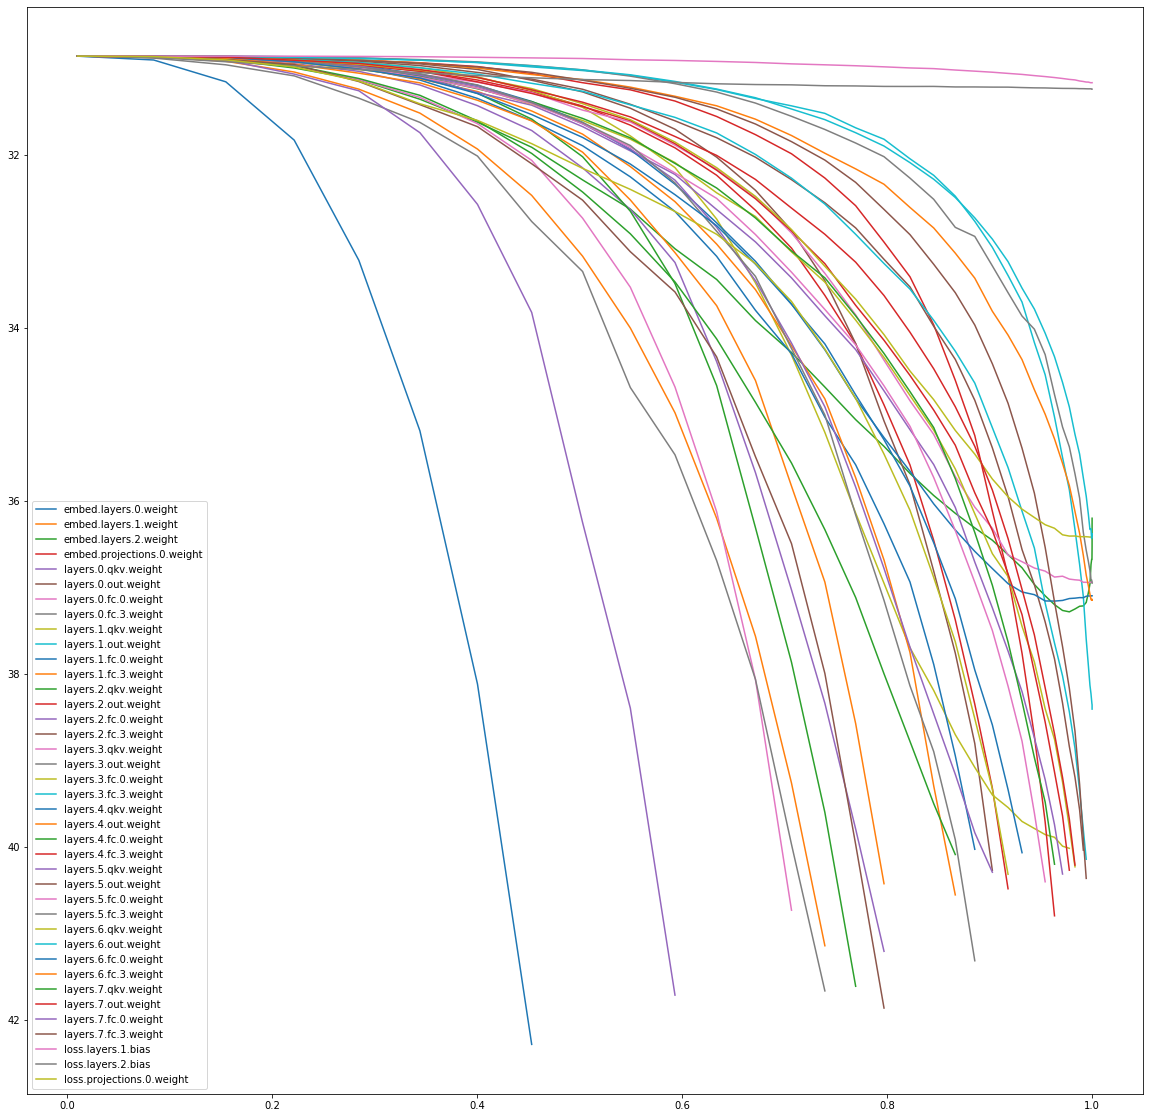

In [8]:
plt.figure(figsize=(20, 20))
plt.gca().invert_yaxis()
for layer_name, (numel, layer_info) in info.items():
    layer_info = np.array(layer_info)
    x = 1 - layer_info[:, 1]
    y = layer_info[:, 2]
    v.line(y, x, 'prune', name=layer_name)
    plt.plot(x, y, label=layer_name)
plt.legend()
plt.show()

In [10]:
info_save = {}
for layer_name, (numel, layer_info) in info.items():
    info_save[layer_name] = [numel, np.array(layer_info)]
(c_sen.res / 'sensitivities.npy').save(info_save)

# Validation of Correct Saving

In [3]:
distill_str = """
pruners:
  test_pruner:
      class: AutomatedGradualPruner
      initial_sparsity: 0.01
      final_sparsity: 1.00
      weights: [layers.6.out.weight]
policies:
  - pruner:
      instance_name: test_pruner
    starting_epoch: 0
    ending_epoch: 10
    frequency: 1
"""
d_c = yaml.load(distill_str)

import distiller
from main import get_net, get_opt, evaluate
c = Config(Wiki / 'shallow,layers_8', device='cuda:0', logger=False).load()
net = get_net(c)
opt = get_opt(c, net)
c.init_model(net, opt=opt, step='max', train=False)
compression_scheduler = distiller.config.dict_config(net, opt, d_c)

In [4]:
data_tr = SampleIterator(c, c.train_batch, split='valid' if c.debug else 'train')
iter_tr = iter(data_tr)
data_val = SequentialIterator(c, c.eval_batch, split='valid')

In [5]:
parameters = dict(net.named_parameters())
layer_name = 'layers.6.out.weight'

In [6]:
def evaluate_step():
    density = distiller.density(parameters[layer_name])
    ppl = np.e ** evaluate(c, data_val, net)['loss']
    return density, ppl

from copy import deepcopy
c_temp = deepcopy(c)
c_temp.res = Wiki / 'temp'

with torch.no_grad():
    print('Initial density %.5g ppl %.5g' % evaluate_step())
    for epoch in range(10):
        compression_scheduler.on_epoch_begin(epoch)
        compression_scheduler.on_minibatch_begin(epoch, minibatch_id=1, minibatches_per_epoch=1)
        x = to_torch(next(iter_tr), c.device).t()
        inputs, labels = x[:-1], x[1:]
        preds = net(inputs, labels)
        loss = preds['loss']
        loss = compression_scheduler.before_backward_pass(epoch, minibatch_id=1,
                                                               minibatches_per_epoch=1,
                                                               loss=loss, return_loss_components=False)
        compression_scheduler.on_minibatch_end(epoch, minibatch_id=1, minibatches_per_epoch=1)
        compression_scheduler.on_epoch_end(epoch)
        print('Epoch %s density %.5g ppl %.5g' % (epoch + 1, *evaluate_step()))
        c_temp.save_state(epoch, c_temp.get_state(net, opt, epoch), link_best=False)

Initial density 1 ppl 37.187
Epoch 1 density 0.99001 ppl 37.187
Saved model /data/scratch/zxyan/micronet/wikitext-103/temp/models/model-0.pth at step 0
Epoch 2 density 0.69531 ppl 37.274
Saved model /data/scratch/zxyan/micronet/wikitext-103/temp/models/model-1.pth at step 1
Epoch 3 density 0.46582 ppl 37.699
Saved model /data/scratch/zxyan/micronet/wikitext-103/temp/models/model-2.pth at step 2
Epoch 4 density 0.29333 ppl 38.714
Saved model /data/scratch/zxyan/micronet/wikitext-103/temp/models/model-3.pth at step 3
Epoch 5 density 0.16976 ppl 40.354
Saved model /data/scratch/zxyan/micronet/wikitext-103/temp/models/model-4.pth at step 4
Epoch 6 density 0.086914 ppl 42.824
Saved model /data/scratch/zxyan/micronet/wikitext-103/temp/models/model-5.pth at step 5
Epoch 7 density 0.036682 ppl 45.522
Saved model /data/scratch/zxyan/micronet/wikitext-103/temp/models/model-6.pth at step 6
Epoch 8 density 0.010864 ppl 48.129
Saved model /data/scratch/zxyan/micronet/wikitext-103/temp/models/model-

In [8]:
with torch.no_grad():
    print('Initial density %.5g ppl %.5g' % evaluate_step())
    for epoch in range(10):
        net, _ = c_temp.init_model(net, opt=None, step=epoch, train=False)
        print('Epoch %s density %.5g ppl %.5g' % (epoch + 1, *evaluate_step()))

Initial density 0.46582 ppl 37.699
Epoch 1 density 0.99001 ppl 37.187
Epoch 2 density 0.69531 ppl 37.274
Epoch 3 density 0.46582 ppl 37.699
Epoch 4 density 0.29333 ppl 38.714
Epoch 5 density 0.16976 ppl 40.354
Epoch 6 density 0.086914 ppl 42.824
Epoch 7 density 0.036682 ppl 45.522
Epoch 8 density 0.010864 ppl 48.129
Epoch 9 density 0.0013631 ppl 49.695
Epoch 10 density 0 ppl 49.508
